In [79]:
import collections
import itertools
import json
import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

In [80]:
with open("data/results/test_1M__post_stats.json") as handle:
    post_stats = json.load(handle)

with open("data/results/test_1M__pairs_first_dates.json") as handle:
    pairs_first_dates = json.load(handle)

with open("data/results/test_1M__pairs_count.json") as handle:
    pairs_count = json.load(handle)

with open("data/results/test_1M__user_to_posts.json") as handle:
    user_to_posts = json.load(handle)

In [81]:
# This may not be necessary as the input seems already sorted, but let us code this defensively.
sorted_post_stats = sorted(post_stats, key=lambda item:  datetime.datetime.strptime(item['date'], "%Y-%m-%dT%H:%M:%S.%f"))

## Distribution of post ranks

[]

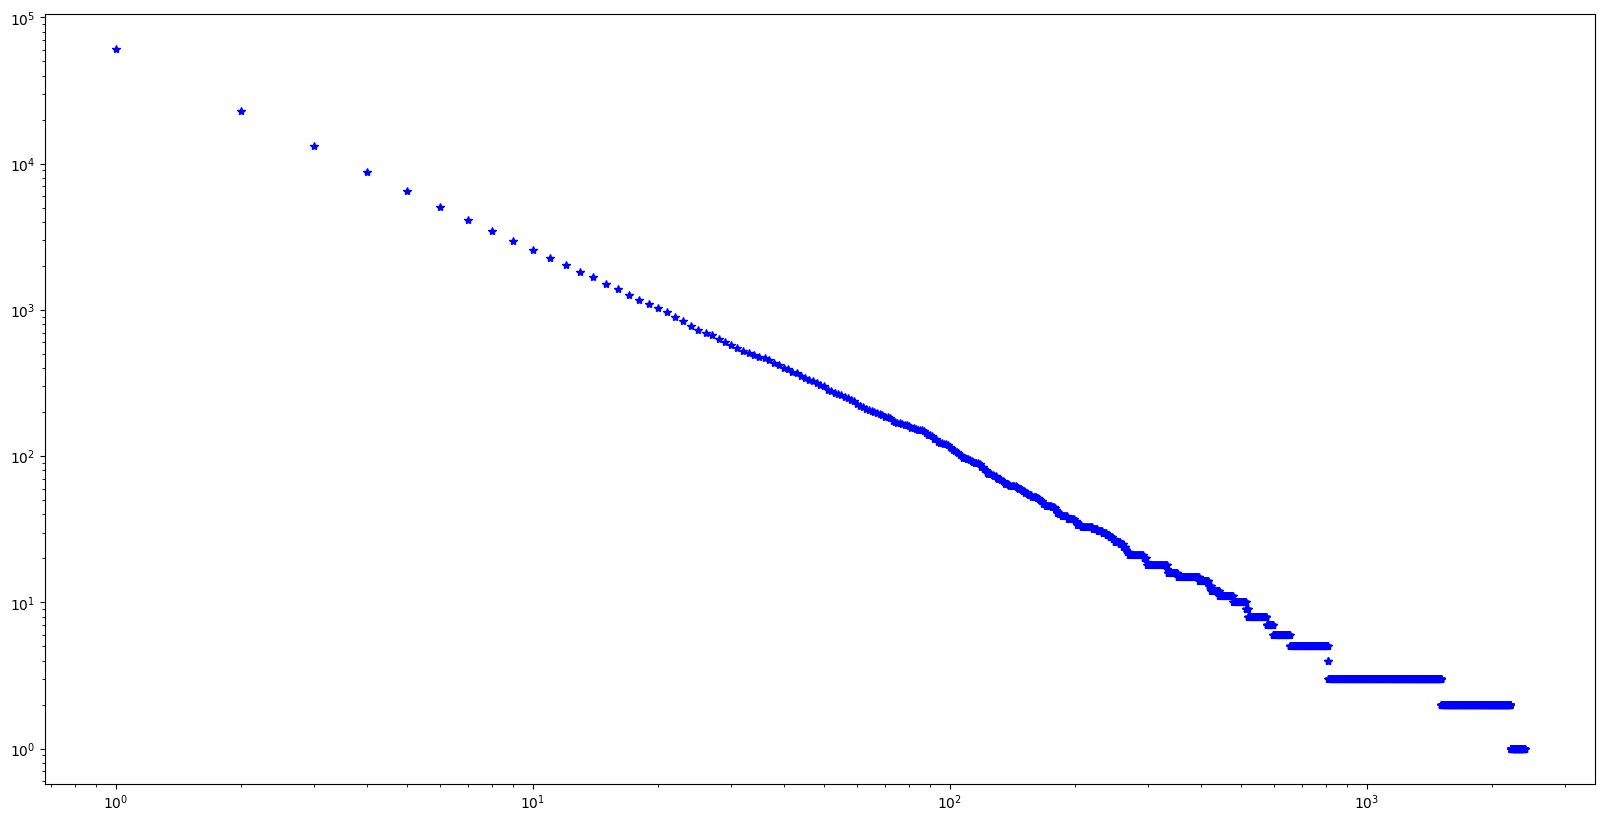

In [122]:
plt.figure(figsize=(20,10))
plt.plot(sorted(post_rank_count.keys()), [post_rank_count[x] for x in sorted(post_rank_count.keys())], "b*")
plt.loglog()

# Probability distributions of a rank $r$ post being novelty/ valuable novelty


Replay the posts in order and collect the following data:
 - number of post created by every user at the time of the kth post
 - identify if the kth post is a novelty / valuable novelty. Based on that,
 - rank of every post: the number of posts that had been created by the same user (including the current one)
 - distribution of post ranks, novelty post ranks, valuable novelty post ranks. Based on that,
 
 *** probability distributions $p_n(r)$ and $p_{vn}(r)$ of a rank $r$ post being novelty/ valuable novelty. ***


In [106]:
VALUE_THRESHOLDS = [25, 50, 100, 200]

user_posts = collections.defaultdict(set)
novel_post_stats = []
post_rank_count = collections.defaultdict(int)
novel_post_rank_count = collections.defaultdict(int)
valuable_novel_post_rank_count = {
    k: collections.defaultdict(int) for k in VALUE_THRESHOLDS
}
stats = collections.defaultdict(int)
for post_stat in tqdm.tqdm(sorted_post_stats):
    try:
        user_posts[post_stat["poster_id"]].add(post_stat["id"])
        post_rank = len(user_posts[post_stat["poster_id"]])
        novelty_count = 0
        is_valuable = {k: False for k in VALUE_THRESHOLDS}
        for imp1, imp2 in itertools.combinations(post_stat["imports"], 2):
            canonical_pair_name = "|".join(sorted([imp1, imp2]))
            if pairs_first_dates[canonical_pair_name]["id"] == post_stat["id"]:
                novelty_count += 1
                for value_threshold in VALUE_THRESHOLDS:
                    if pairs_count[canonical_pair_name] >= value_threshold:
                        is_valuable[value_threshold] = True
                novel_post_stats.append(
                    {
                        "poster_id": post_stat["poster_id"],
                        "id": post_stat["id"],
                        "current_post_count": len(user_posts[post_stat["poster_id"]]),
                        "canonical_pair_name": canonical_pair_name,
                        "pair_total_use": pairs_count[canonical_pair_name],
                    }
                )
        if novelty_count > 0:
            stats["novelty_post_count"] += 1
            novel_post_rank_count[post_rank] += 1
            for value_threshold in VALUE_THRESHOLDS:
                if is_valuable[value_threshold]:
                    valuable_novel_post_rank_count[value_threshold][post_rank] += 1
        else:
            stats["non_novel_post_count"] += 1
        stats["total_post_count"] += 1
        post_rank_count[post_rank] += 1
    except Exception as exc:
        stats[exc] += 1

print("STATS:")
for k, v in stats.items():
    print(f"\t{k}: {v}")

# Calculate it for the richest domain of the valuable ratios, that is, for the smallest threshold.
novel_ratio = {
    k: novel_post_rank_count.get(k, 0) / post_rank_count.get(k, 1)
    for k in sorted(valuable_novel_post_rank_count[min(VALUE_THRESHOLDS)].keys())
}

valuable_novel_ratio = {}
for value_threshold in VALUE_THRESHOLDS:
    valuable_novel_ratio[value_threshold] = {
        k: valuable_novel_post_rank_count[value_threshold].get(k, 0) / post_rank_count.get(k, 1)
        for k in sorted(valuable_novel_post_rank_count[value_threshold].keys())
    }

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187919/187919 [00:06<00:00, 28454.94it/s]

STATS:
	novelty_post_count: 15091
	total_post_count: 187919
	non_novel_post_count: 172828


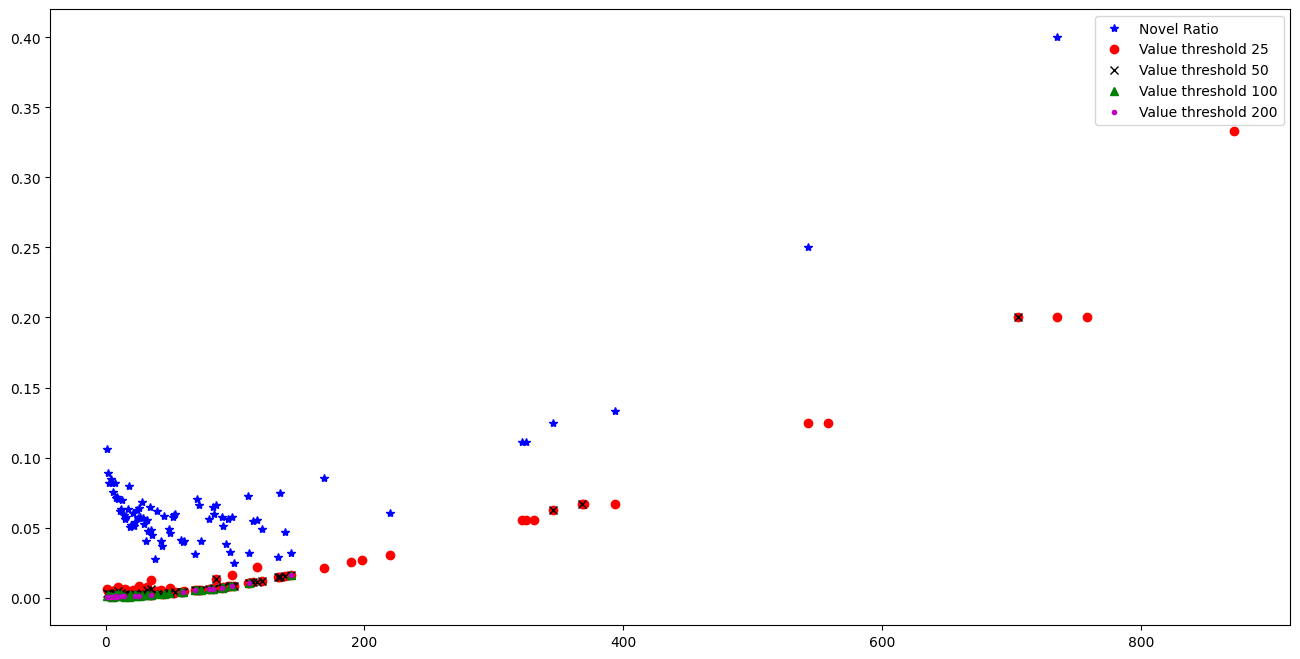

In [108]:
plt.figure(figsize=(16,8))
plt.plot(sorted(novel_ratio.keys()), [novel_ratio[x] for x in sorted(novel_ratio.keys())], "b*", label="Novel Ratio")
forms = "ox^."
colors ="rkgm"
for index, value_threshold in enumerate(VALUE_THRESHOLDS):
    plt.plot(
        sorted(valuable_novel_ratio[value_threshold].keys()),
        [valuable_novel_ratio[value_threshold][x] for x in sorted(valuable_novel_ratio[value_threshold].keys())],
        f"{colors[index]}{forms[index]}", label=f"Value threshold {value_threshold}")
plt.legend()

Text(0, 0.5, 'Probability of being novel/valuable novel')

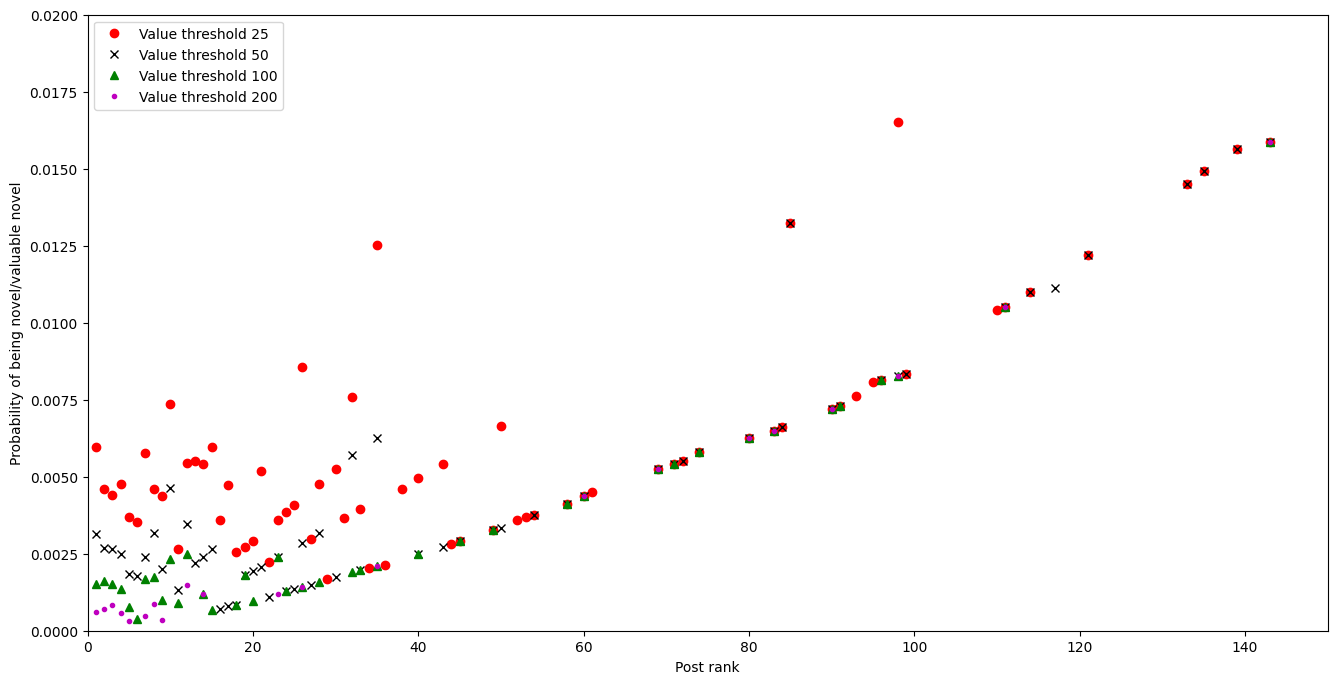

In [116]:
plt.figure(figsize=(16,8))
forms = "ox^."
colors ="rkgm"
for index, value_threshold in enumerate(VALUE_THRESHOLDS):
    plt.plot(
        sorted(valuable_novel_ratio[value_threshold].keys()),
        [valuable_novel_ratio[value_threshold][x] for x in sorted(valuable_novel_ratio[value_threshold].keys())],
        f"{colors[index]}{forms[index]}", label=f"Value threshold {value_threshold}")
plt.legend()
plt.xlim(0, 150)
plt.ylim(0, 0.02)
plt.xlabel("Post rank")
plt.ylabel("Probability of being novel/valuable novel")

## Comparison of rank distributions among all posts vs novel posts

In [86]:
impacts = pd.DataFrame(novel_post_stats)

#impacts["cm_impact"] = impacts.groupby(["poster_id", "id", "current_post_count"])["pair_total_use"].transform("sum")
# for now, we should only focus on the highest, not the cumulative impact. 10 lib pairs of 20 cites each != one pair with 200 cites.
impacts["max_impact"] = impacts.groupby(["poster_id", "id", "current_post_count"])["pair_total_use"].transform("max")
impacts_unique = impacts.drop_duplicates(subset=['id'], keep='first'); impacts_unique

,poster_id,id,current_post_count,canonical_pair_name,pair_total_use,max_impact
0,1384652,802,1,MySQLdb|cgi,33,161
3,116,1840,1,select|sys,156,156
9,394,5909,2,re|urllib,557,557
10,985,8020,1,sys|time,1990,1990
11,995,15931,1,StringIO|lxml,86,86
...,...,...,...,...,...,...
36175,2473567,26688318,1,future_builtins|multiprocessing,1,1
36176,1531116,26688624,17,StringIO|spynner,1,1
36177,2676531,26692169,4,flask|shared,1,1
36178,122792,26694246,8,motor|pymongo,1,1


In [119]:
def custom_bin(x):
    bin_borders = [1, 10, 25, 50, 100, 200]  
    for border in bin_borders:
        if x <= border:
            return f"<={border}"
    return "INF"

/tmp/ipykernel_1105/2703106532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impacts_unique["custom_bin"] = impacts_unique.current_post_count.map(custom_bin)


array([<Axes: ylabel='Novel Posts'>], dtype=object)

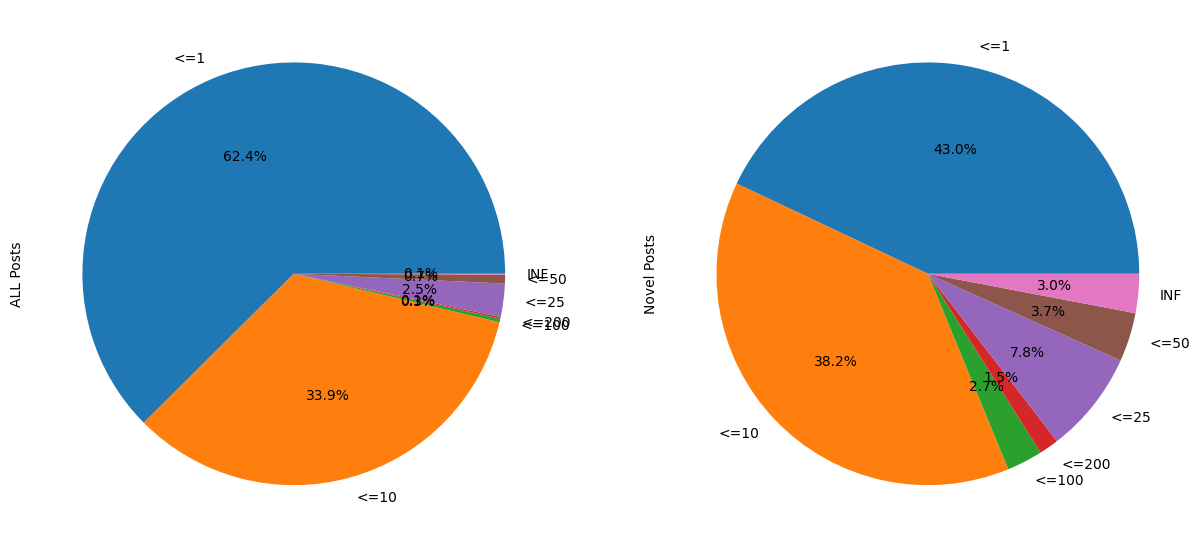

In [120]:
# compare this with the post distribution among users using ALL posts.
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(15,15))

# All posts chart
all_posts = pd.DataFrame({k: len(v) for k, v in user_to_posts.items()}.items(), columns=["user_id", "post_count"])
all_posts["custom_bin"] = all_posts.post_count.map(custom_bin)
all_posts.groupby(["custom_bin"])["user_id"].count().plot.pie(autopct='%1.1f%%', startangle=0, ax=axes[0], subplots=True, label="ALL Posts")

# Novelty Chart
impacts_unique["custom_bin"] = impacts_unique.current_post_count.map(custom_bin)
impacts_unique.groupby(["custom_bin"])["id"].count().plot.pie(autopct='%1.1f%%', startangle=0, ax=axes[1], subplots=True, label="Novel Posts")

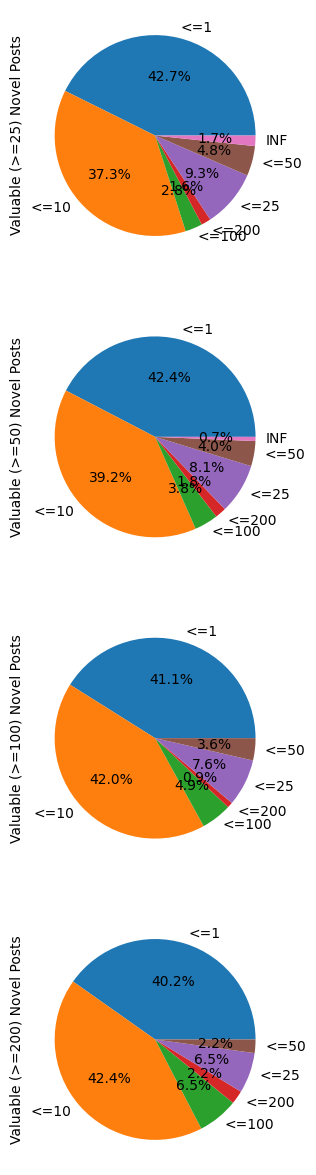

In [121]:
# Valuable Novelty
fig, axes = plt.subplots(nrows=len(VALUE_THRESHOLDS),ncols=1, figsize=(15,15))
val_impacts = {k: impacts_unique[impacts_unique.max_impact > k] for k in VALUE_THRESHOLDS}
for index, k in enumerate(VALUE_THRESHOLDS):
    val_impacts[k].groupby(["custom_bin"])["id"].count().plot.pie(
        autopct='%1.1f%%', startangle=0, ax=axes[index],
        subplots=True, label=f"Valuable (>={k}) Novel Posts")